# Optimising HIP kernels

The performance of HIP kernels is a complex **multi-dimensional optimisation problem**. It depends not only on efficient utilisation of hardware threads in compute units, but also on the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries such as [rocBLAS](https://rocblas.readthedocs.io/en/rocm-5.6.1/) and [CuBLAS](https://developer.nvidia.com/cublas) are the **best way** to achieve optimal compute performance, however pre-packaged solutions are **not always available** for your chosen algorithm. At the same time, HIP implementations the hardware they run on often have smart technologies built-in to optimise processing for commonly used computing operations. Sometimes the simplest approach works best! At other times better compute performance comes at a **significant increase** in the complexity of a program. When developer time is critical, a piece of code that is performant but complex to understand may not be **ideal** for progress. While HIP is mostly targeted at using GPU's, there is a [CPU implementation](https://github.com/ROCm-Developer-Tools/HIP-CPU/) available, and CPU and GPU architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. **Experimentation to see which strategy works best is the key!** In the following sections we will explore a number of strategies that make a difference to kernel performance. If your kernel runtimes are small compared to IO then kernel performance optimisation isn't going to be that useful!

## Compile software

There are a number of different strategies for performing matrix multiplication. We compile each one with the code below:

In [1]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:../install/bin"

# At a Bash terminal you need to do this instead
# source ../env

In [2]:
!build all

[  1%] Built target hip_helper
[  3%] Built target hello_devices.exe
[  5%] Built target hello_devices_mpi_onefile.exe
[  7%] Built target hello_devices_mpi.exe
[  9%] Built target hello_jobstep.exe
[ 11%] Built target mat_mult_profiling_mpi.exe
[ 13%] Built target mat_mult.exe
[ 15%] Built target mat_mult_bug.exe
[ 16%] Built target mat_mult_memcheck.exe
[ 18%] Built target mat_mult_printf.exe
[ 20%] Built target mat_mult_profiling.exe
[ 22%] Built target mat_mult_managed_mem.exe
[ 24%] Built target mat_mult_pinned_mem.exe
[ 25%] Built target mat_mult_pitched_mem.exe
[ 26%] Built target mat_mult_shared_faulty.exe
[ 28%] Built target mat_mult_shared_vector.exe
[ 30%] Built target mat_mult_shared.exe
[ 32%] Built target vector_types.exe
[ 33%] Built target atomics.exe
[ 34%] Built target mat_mult_shared_A_col.exe
[ 36%] Built target mat_mult_shared_A_flat_col.exe
[ 37%] Built target mat_mult_tile_shared_AB_flat_col.exe
[ 39%] Built target mat_mult_AT.exe
[ 40%] Built target mat_mult_BT.

## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partitioned into compute units, and each compute unit provides a number of hardware threads that execute the instructions in software threads. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Compute units (cores) have a clock cycle and can perform a limited number of instructions per cycle. During the execution of a program, instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and performance may be impacted. 

### Cache topics

#### Cache hierarchy

The fastest memory locations in a processor core (either CPU or GPU) are the registers. They operate at or near the same clock speed as the core and are located on the processor die close to the hardware that performs compute operations. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (tens of kB)
* Shared memory, fast/fastest on-die memory (tens of kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most frequently used memory is stored in the lowest level (L1, L2) caches. Memory that is not used as often is evicted to the slower (L2, L3) caches as necessary. Memory that is rarely used is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at a processor core in units of individual bytes, instead it arrives in transactional units called **cache lines**. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a single value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from **main memory** at the cost of wasted processor cycles. 

> A key to achieving good performance with memory access is to **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of a memory access. 

In the context of HIP, it is advantageous if neighbouring threads in a block access neighbouring memory locations. Then memory transfers can be shared among threads in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
| Shared/LDS | NA | ~30-100 |
|   L1  | ~4 | ~30-100|
| L2 | ~8-12 | ~175-300 |
| L3 | ~24-40 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers 1](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4), [CPU numbers 2](https://www.anandtech.com/show/16529/amd-epyc-milan-review/4).

From this table we can see that the memory latency for GPU is orders of magnitude slower than for CPU's. GPU vendors get around this problem by having **deep execution pipelines** with many teams of hardware threads active (ready to execute instructions) per processor core. If one team stalls while waiting for memory then another team can take over. It is therefore desirable to have as many teams ready to take over as a compute unit will support. The ratio of active teams to the maximum number of teams on a compute unit is called **occupancy**. It is usually desirable to achieve a high degree of occupancy for a kernel.

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
| LDS | NA | ~1000-3000
|   L1  | 2000-4000 | ~1500+ |
| L2 | 1000-1500 | ~1000-7000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1600 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers 1](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf), [GPU Numbers 2](https://www.amd.com/content/dam/amd/en/documents/instinct-business-docs/white-papers/amd-cdna2-white-paper.pdf)

#### Thoughts on latency and throughput with HIP kernels in mind

With either CPU or GPU compute units we must make sure to make best use of cache lines. This means creating blocks whose neighbouring threads also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significantly faster on a GPU device, however memory will take more cycles to arrive. 

### CPU architecture specifics

CPU's usually have fewer than 100 compute units (cores), and each compute unit has sophisticated instruction handling and nice things like pre-emptive memory fetching and branch prediction. One can think of CPU compute units as **smart workers**, and the cache latency timings above indicate CPU's are more nimble than GPU's. The compute units in a CPU each provide a number of hardware threads that can execute instructions independently of each other. CPU's have registers, and on-die L1 and L2 caches. The L3 cache is usually also on-die, but is in an area that is commonly accessible to other compute units. In <span>AMD&trade; Zen&trade; 3+</span>  CPU's the compute units are grouped into chiplets of 8 cores called core complexes (CCX's), and an L3 cache on the chiplet services all 8 cores. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:80%">
    <img style="vertical-align:middle" src="../images/cpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Section of a CPU processor, showing Compute Units (cores), each with floating point SIMD units and integer pipelines. </figcaption>
</figure>

In terms of math operations, CPU's have integer processing and SIMD (Single Instruction Multiple Data) math units that can perform operations on vectors of numbers **with one instruction**. At the time of writing, vectors of up to 8-16 floats (AVX2-AVX512) may be processed at a time using the SIMD units of a CPU. It depends largely on what kind of vector instructions are supported by the chipset.

> Getting good floating point performance from a CPU is **critically** dependent on wether or not one can effectively leverage the SIMD units of the CPU. Using **vectors** is a way to provide strong hints the to implementation's device compiler to emit vector instructions that work on the CPU.

#### Example specifications

Here are some specifications of CPU's for Pawsey's previous generation supercomputer Magnus, and the latest supercomputer Setonix.

| Computer | CPU | Peak clock frequency (GHz) | Cores | Hardware threads | L1 Cache (KB) | L2 Cache (KB) | L3 cache (MB) | FP SIMD width (bits) | Peak TFLOPS (FP32 calculated) |
|:----:|:----:|-----:| -----: | -----: | :----: | :----: | :----: | :----: | :----: |
| Magnus | Intel Xeon 2690 v3 | 3.5 | 12 | 24 | 12x32 | 12x256 | 30 | 256 | 0.34 |
| Setonix |AMD EPYC 7763 | 3.5 | 64 | 128 | 64x32 | 64x512 | 8x32 | 256 | 3.6 |

Source for the CPU specs [Xeon](http://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E7-4850%20v4.html) and [Epyc](https://en.wikipedia.org/wiki/Epyc).

### GPU architecture specifics

There is some confusing terminology on what exactly is a processor core in GPU's. We define a core as that which can fetch and issue instructions. Like CPU's, GPU's also have cores or compute units, called **Streaming Multiprocessors** in NVIDIA terminology, **Compute Units** in AMD terminology, and **Xe-Cores** in Intel terminology. Each of these compute units schedule instructions, move data in the caches, and can be considered the **actual cores** in a GPU processor. 

Instructions issued by the compute units are executed by a team of hardware threads, each with SIMD-like math units that perform physical operations on data in **lock-step** with the units in other hardware threads (lanes) in the team. These units are called **CUDA Cores** in NVIDIA terminology, and **Shader Cores** in AMD terminology. On NVIDIA hardware, teams are 32-64 lanes wide and are known as **warps**, and on AMD hardware teams are also 32-64 lanes wide and are known as **wavefronts**. The diagram below shows the layout of lanes for compute units.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:100%">
    <img style="vertical-align:middle" src="../images/gpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Floating point units (FP32), registers, and caches for different GPU's. </figcaption>
</figure>

There is a slight bit of confusion to navigate here. In AMD/CUDA terminology a *thread* is synonymous with the execution of a kernel instance as part of a block. It is a concept from the software space. In the hardware space, kernel instructions are physically executed by a hardware thread in a lane of a thread team. One or more thread teams may particpate in a block, which means neighbouring threads in a block may not be part of the same thread team. 

An efficient choice for the number of threads in a block is naturally a **multiple** of the team size. The **warpsize** field of a **hipDeviceProp_t** structure from a call to **hipGetDeviceProperties** will inform you how many lanes are in a thread team.

#### SIMT and how it differs from SIMD

The model discussed above for executing instructions in lock-step over thread teams is known as SIMT (Single Instruction Multiple Threads). As with SIMD, each compute unit executes the same instruction over every hardware thread (lane) in the team. The crucial distinction between SIMD and SIMT is that each lane of a thread team has a degree of self determination. Each lane has access to its own data and the ability to execute a unique (to a thread) code path. Since lanes in a team execute in lock-step with each other, all hardware threads in the team **must** come along for the ride and participate in **every** unique code path. It is therefore good for performance to keep the number of unique paths to a **minimum**. Results from threads that are not meant to participate in a code path are **masked out**.  

In summary, for SIMD a single vector instruction **must apply to all elements** of a vector and no path divergence is possible. SIMT allows for hardware threads to follow unique code paths, with the condition that all code paths must be visited by every hardware thread in the team, even if the their results are masked out.

#### Lightweight thread switching 

A compute unit can switch between thread teams with **minimal overhead**, so it can switch to a thread team that is ready to execute instructions while other thread teams wait for memory to arrive. 

#### Example specifications for supercomputing GPU's

Here are some specifications on more recent GPU's for supercomputing. NVIDIA has separate math units for 32-bit and 64-bit floating point instructions. AMD has a more SIMD-like approach to computing floats, which means that on the MI200 architecture a 64-bit floating point arithmetic can proceed at the same rate as 32-bit math.

| Card | Boost clock (GHz)| Compute Units | FP32 Processing Elements | FP64 Processing Elements (equivalent compute capacity) | L1 Cache (KB) | L2 Cache (KB) | device memory (GB) | Peak Tflops (FP32)| Peak Tflops (FP64)|
|:----:|:-----| :----- | :----- | :---- | :---- | :---- | :---- | :---- | :---- |
| NVIDIA Tesla K40 | 0.875 | 15 | 2880 | 960 | 48 | 1536 | 12 |5.04|1.68|
| NVIDIA Tesla M60 |1.178 |32| 4096| NA | 32x2x48 | 3072 | 8 |4.8|0.151|
| NVIDIA Tesla P100 |1.480| 56 | 3584 | 1792 | 56x64| 4096 | 16 |10.6|5.3|
| NVIDIA Tesla V100 |1.530| 80 | 5120 | 2560 | 80x96 | 6144 | 16 |15.7|7.8|
| NVIDIA Tesla A100 |1.410| 108 | 6912 | 3456 | 108x164 | 40960 | 40 |19.5|9.7|
| AMD Radeon Instinct MI50 |1.746 | 60 | 3840 | (1920) | 60x16 | 4000 | 16 |13.4 |6.7|
| AMD Radeon Instinct MI100 |1.502 | 120 | 7680 | (3480)  | 120x16 | 8000 | 32|23.1 |11.5|
| AMD Radeon Instinct MI200 |1.7 | 208 | 13312 | 13312 | 208x16 | 16000 | 128 | 45.3 | 45.3 |
| AMD Radeon Instinct MI250x |1.7 | 220 | 14080 | 14080 | 220x16 | 16000 | 128 | 47.9 | 47.9 |

Source for these numbers [Acceleware](https://training.acceleware.com/blog/Tesla-Meets-Maxwell), [NVIDIA](https://devblogs.nvidia.com/inside-volta/), [AMD](https://www.amd.com/en/graphics/servers-radeon-instinct-mi), [Microway](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-maxwell-gpu-accelerators/), and [TechPowerup](https://www.techpowerup.com/gpudb/2760/tesla-m60).

#### Occupancy

GPU vendors overcome memory latency shortcomings by having **deep execution pipelines**, meaning that multiple teams (warps or wavefronts) can be active (in the process of executing instructions) on a compute unit at any one time. A block can have more than one thread team in it and a compute unit can switch focus between thread teams in blocks **with minimal overhead**, to hide latencies while memory is being fetched. Naturally one would want as many thread teams active as possible, and **Occupancy** is a term used to describe the ratio of how many teams **are active** vs how many **can be** active. Full occupancy is generally good for performance, but there are a number of limits that can impact occupancy, such as the following:

* limits on blocks per compute unit
* limits on the number of thread teams per compute unit
* limits on threads per block
* limits on threads per compute unit
* limits on registers per compute unit
* limits on registers per block
* limits on shared memory per compute unit
* limits on shared memory per block

If the number of software threads in a block is too low, then occupancy is reduced by the limit of permissible blocks per compute unit. If it is too large then you either might not be able to schedule a kernel, or synchronisation between thread teams becomes time consuming. 

##### Registers and occupancy

If each thread uses too many registers, or the block uses too much shared memory, then that can reduce performance through either limiting occupancy or spilling over into scratch (global memory) at the price of greater latency. If your kernel is large and uses **too many registers** then consider finding ways to split the computation over successive lightweight kernel calls. You can find the number of registers deployed and occupancy achieved with the hipcc compiler flags `-Rpass-analysis=kernel-resource-usage` and `--save-temps`. On Setonix this flag currently only works on versions of rocm more recent than `5.2.3`. For example, we compile the program `mat_mult_float.exe` with this command

```bash
module swap rocm/5.2.3 rocm/5.7.3
hipcc --offload-arch=gfx90a -I../common ../common/hip_helper.cpp mat_mult_float.cpp -Rpass-analysis=kernel-resource-usage -o mat_mult_float.exe
```

See [this AMD blog post on register pressure](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-register-pressure-readme/) for more helpful tips on reducing register pressure and increasing occupancy.

The function **hipGetDeviceProperties** can help us get a struct from which we can query the maximum number of threads that can be active on a Compute Unit or Streaming Multiprocessor (in the field `maxThreadsPerMultiProcessor`). If we know the number of registers that are available per compute unit, then dividing available registers by maximum number of threads is an indication of how many registers are available to a thread if full occupancy is to be achieved.

The tool Omniperf can also highlight how many Vector General Purpose Registers (VGPRS) and Scalar General Purpose Registers (SGPRS) are being used in a kernel. The SGPR's are to store variables that do not vary over a wavefront, and the VGPR's are to store variables per thread.

##### Available work as a limit on occupancy

Sometimes occupancy is simply limited by not having enough parallel work scheduled to keep a sufficient number of work items busy.

For the matrix multiplication algorithm as it stands, we are using a small number of private variables and we have one work item for every element in matrix C. For a matrix size of $1024^{2}$ there can be just over $1,048,576$ or threads (kernel invocations). We will see if this is enough work to keep the MI250X and NVIDIA RTX 3060 GPU's at full occupancy.

###### Limits for the MI250X

From this [source](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-register-pressure-readme/#:~:text=This%20means%20that%20the%20physical,the%20most%20common%20occupancy%20limiters.) and from the `maxThreadsPerMultiProcessor` property, the CDNA2 architecture present in the Radeon Instinct MI250x GPU may have 32 wavefronts (32x64=2048 threads) active on a compute unit at any one time. From the documentation [AMD Instinct MI200" Instruction Set Architecture](https://www.amd.com/content/dam/amd/en/documents/instinct-tech-docs/instruction-set-architectures/instinct-mi200-cdna2-instruction-set-architecture.pdf) we know that there are 800 x 32-bit Scalar General Purpose Registers (SGPRs) and 131072 x 32-bit Vector General Purpose Registers (VGPRs) per compute unit.  Since 32 wavefronts can be active on a compute unit, then the number of 32-bit **SGPRs** consumed by a wavefront must ideally be less than **800/32 = 25**, and the number of 32-bit VGPRs consumed by a wavefront must ideally be **131072/2048 = 64** in order for full occupancy to be maintained. Since there are 110 compute units in MI250x GCD there can be 110x32x64 = 225,280 threads active at any one time on a MI250x.

###### Limits for NVIDIA compute capability 8.6

From the occupancy table in [NVIDIA Nsight Compute](https://developer.nvidia.com/nsight-compute)  and from the `maxThreadsPerMultiProcessor` property, an NVIDIA RTX 3060 with CUDA compute capability 8.6 can have 48 warps (48x32=1536 threads) active per streaming multiprocessor active at any one time, as well as 65,536 registers. Therefore at fully occupancy each kernel must ideally consume up to **65536/1536 ~= 42** registers before occupancy will be affected. Since there are 28 streaming multiprocessors then 28x1536 = 43,008 threads may be active at any one time. 

With either architecture we know there is **more than enough work scheduled** to keep the Compute Units / Streaming Multiprocessors busy. In the default matrix multiplication algorithm there is no shared memory usage and very little register usage, so we anticipate that the GPU can sustain full occupancy with the right block size.

##### Launch bounds as a compiler hint

When deciding how many registers to allocate to a kernel, the compiler takes account the maximum number of threads that are possible per block and the number of blocks that will run per compute unit or streaming multiprocessor. On [AMD architectures](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-register-pressure-readme/) registers are allocated assuming a maximum of 1024 threads per block may be used at launch. One can modify this assumption using the `__launch_bounds__(MAX_THREADS_PER_BLOCK, MIN_BLOCKS_PER_CU, MAX_BLOCKS_PER_CU)` kernel qualifier. An example kernel with launch bounds specified is below:

```C++
#define MAX_THREADS_PER_BLOCK 256
#define MIN_BLOCKS_PER_CU 1
#define MAX_BLOCKS_PER_CU 8

// standard matrix multiply kernel
__global__ void __launch_bounds__(MAX_THREADS_PER_BLOCK, MIN_BLOCKS_PER_CU, MAX_BLOCKS_PER_CU) mat_mult (
        float_type* A, 
        float_type* B, 
        float_type* C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    ///...
} 
```
For our kernels we plan on using up to 1024 threads per block, and during compilation we see that the number of registers used is low. Therefore we do not need to try using launch bounds to optimise performance.

##### Tips for maximising occupancy

Some tips for maximising occupancy are:

* Schedule blocks whose number of threads are a multiple of thread team size.
* Keep the number of private variables (register usage) low. From [this blog post on register pressure](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-register-pressure-readme/) and [this blog post on optimising a Laplacian](https://gpuopen.com/learn/amd-lab-notes/amd-lab-notes-finite-difference-docs-laplacian_part3/), some tips to reduce register usage are:
    * Split the computation over successive lighter-weight kernels.
    * Avoid passing in objects to kernels if they use a lot of memory.
    * Avoid allocating large static arrays within a kernel.
    * Declare variables within code blocks, use these variables close to the computation.
    * Function calls from within a kernel are inlined. Avoid too many function calls.
    * Set the `__launch_bounds__` qualifer on kernels to set expectations for the compiler on the maximum number of threads in a block and the minimum number of active thread teams to have ready.
    * Manually use shared memory to store extra variables.
* Keep the shared memory usage low
* Keep the workload consistent across blocks
* If possible schedule enough work so that every compute unit in the GPU can achieve full occupancy.

#### Instruction branching in GPU kernels (thread divergence)

Work-items in thread teams on GPU's execute instructions in **lock-step** with each other. One needs to be careful then to avoid building kernels where individual work-items execute different (and lengthy) code paths, because then the whole team has to visit each code path. For example the following kernel code is not ideal because work-items with even-numbered worker_id's execute work package 1 while the odd-numbered workers are masked out, then the odd-numbered threads in the team execute work package 2 while the even threads are masked out. In either case the team as a whole must visit every code path together, which degrades GPU performance.

```C++
    int tid = threadIdx.x;
    
    if (tid % 2 == 0) {
    
        // Work package 1
    
    } else {
        
        // Work package 2
    
    }
    ...
```

#### Matrix and tensor core availability in HIP

Up to this point I have completely skipped over the extra matrix (AMD, INTEL) and tensor (NVIDIA) core functionality present in modern GPU's. This special matrix processing machinery has applications in machine learning and deriving the very best performance out of your hardware. On AMD and NVIDIA hardware these instructions are accessed through vendor-specfic instructions. The use of these instructions comes at the expense of HIP portability, however in your kernel you can use an `#ifdef` with macros such as `__HIP_PLATFORM_NVIDIA__` or `__HIP_PLATFORM_AMD__` to work out which vendor instruction to use.

## Strategies to optimise the use of your compute devices

With this hardware background in mind we can now go about exploring ways to improve performance in kernels. The matrix multiplication example is a trial algorithm we can use to see how specific techniques respond. There are a few in-depth articles exploring how to optimise matrix multiplication in various different ways. An in-depth exploration of matrix multiplication by [Simon Boehm](https://siboehm.com/articles/22/CUDA-MMM) is also a good resource.

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations (i.e multiplications and additions) its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$), teraFLOPS ($10^{12}$), petaFLOPS ($10^{15}$), and exaFLOPS ($10^{18}$) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming hardware is often optimised for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX 3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to having 64 times fewer 64-bit capable processing elements. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed in a single clock cycle by AVX-512 instructions.

Compute performance within a kernel is also determined by the type of math instruction performed. Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (costing a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, however waiting for memory is time consuming, and during those times kernel math can often be done for free.

### Arithmetic intensity and working out where to spend the effort

The **Arithmetic intensity** of an algorithm is the ratio of FLOPS computed per Byte transferred. It helps us gauge if an algorithm is likely to be constrained by bandwidth or floating point performance. For our problem matrix A is of size ($N_{0,C}, N_{1,A}$) and B is of size ($N_{1,A}, N_{1,C}$). Every element of matrix C requires $N_{1,A}$ loads from A, $N_{1,A}$ loads from B, and 1 store to C. It also requires $N_{1,A}$ multiplications and $N_{1,A}$ additions. The arithmetic intensity of matrix multiplication is then

$$ a = \frac{2N1_A}{(2N1_A+1)b} $$

where **b** is the number of bytes stored per element. When $N1_A$ is large the arithmetic intensity for matrix multiplication is

$$ a \approx \frac{1}{b}. $$

If a processor has a peak floating point performance of $F_{P}$ FLOP's/second, and a particular cache can feed that processor at a peak bandwidth of $B_{P}$ bytes/second then we can calculate a floating point limit that is dependent on memory bandwidth.

$$F_{B} = a  \frac{\mbox{FLOP}}{\mbox{byte}} B_{P}\frac{\mbox{byte}}{\mbox{second}} = a B_{P} \frac{\mbox{FLOP}}{\mbox{second}}$$ 

The actual attainable floating point performance will be either $F_{B}$ or $F_{P}$, whatever is lower. If we set $F_{B} = F_{P}$ then we can solve for the crossover point in arithmetic intensity.

$$a_{0}=\frac{F_{P}}{B_{P}}$$

Therefore the limits (or roofline) on performance is as follows:  

$$
F = \left \{
\begin{array}{rl}
aB_{P} & \mbox{if} \space a<\frac{F_{P}}{B_{P}},\\
F_{P}& \mbox{otherwise}
\end{array}
\right .
$$

For example, the AMD Mi250x GPU processor has a peak 32-bit floating point processing rate of $F_{P} = 47.9$ TFLOPS and a peak memory bandwidth of $F_{B}=3.2$ TB/s from global memory. Problems will be constrained by memory bandwidth up to an arithmetic intensity of: 

$$a_{0}=\frac{47.9}{3.2} \approx 15$$

for more information see the [Wikipedia Article on Roofline Models](https://en.wikipedia.org/wiki/Roofline_model).

Usually the arithmetic intensity for processors is much larger than $\frac{1}{b} $. Boosting the F/B ratio for matrix multiplication through reducing $b$ is a way forward for getting better performance. Some thoughts on this are as follows:

* We are not going to get anywhere near the rated peak performance of the compute device without employing some form of memory reuse.
* Optimising memory transfers is where we should concentrate our efforts.
    * Lowering the precision of data will increase the F/B ratio.
    * Find optimal block sizes that balance occupancy and workgroup size and the size of memory requests. 
    * Try to reuse information in lower level caches.
    * Rearrange memory access patterns to access memory in a contiguous way.
* We can likely get most of compute operations done during memory transfers.
* We need good occupancy so the GPU can switch to another workgroup while waiting for memory.
* Speedups over a CPU implementation are more likely to be limited to the difference in memory bandwidth speeds.

### Testbench setup

In this workbook we are going to try a number of strategies to optimise matrix multiplication. Performance of a kernel is a non-linear function of the block size, therefore for fairness on each strategy it is important to find the **global minimum** in runtime for the landscape of possible choices for block sizes.

In <a href="../common/hip_helper.cpp">hip_helper.cpp</a> is a function called **h_optimise_block** that takes in a set of N block size experiments in a file called **input_block.dat** (of size (N, 3), row-major, and type **uint32_t**), collects kernel timing statistics for each experiment, and writes the output to **output_block.dat** (of size (N,2), row-major, and type **double**) with dimension 1 containing the mean and standard deviation of kernel runtimes. There are a number of different implementations of matrix multiplication in this directory. Each has been set up to use **h_optimise_local** to read **input_block.dat** and write to **output_block.dat** . The file [benchmark.py](benchmark.py) constructs **input_block.dat** for each implementation, runs the experiment, and collects the timing results into a file called **benchmark.json**. 

The matrix sizes for **A**, **B**, and **C** for the test was $1024^2$, which might be different than is contained in the file [mat_size.hpp](mat_size.hpp) which governs the size at compile time. We have pre-collected timing results for each strategy using 1-4 HIP compute devices on Setonix, and the results are in the sub-directory [benchmarks/setonix.json](benchmarks/setonix.json).  The following code loads these benchmarks and constructs a validation test. 

In [3]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../common"))
import subprocess
import json
import py_helper

%matplotlib widget

defines=py_helper.load_defines("mat_size.hpp")

NCOLS_A = defines["NCOLS_A"]
NROWS_C = defines["NROWS_C"]
NCOLS_C = defines["NCOLS_C"]

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

# Construct validation tests
mat_mul_double=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float64)
mat_mul_float=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float32)

# Make up objects for timing results and local optimisation
timings=py_helper.TimingResults()
local_opt=py_helper.LocalOpt()

# Load the Setonix benchmark
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "setonix.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "setonix_restrict.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "laptop.json"))
#benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "workstation.json"))
benchmark=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmark.json"))

gpu_id=0

# Print the benchmarks
print("Keys in benchmark")
for key in benchmark:
    print(f"\"{key}\"")

Keys in benchmark
"Single precision naive (GPU)[0]"
"Single precision coalesced1 (GPU)[0]"
"Single precision coalesced2 (GPU)[0]"
"Double precision (GPU)[0]"
"Single precision (GPU)[0]"
"Shared A (GPU)[0]"
"Shared A col (GPU)[0]"
"Shared_A_flat_col (GPU)[0]"
"Tile shared_AB_flat_col (GPU)[0]"
"Tile shared_AB (GPU)[0]"


### Data precision

In scientific computing the precision and range of 64-bit arithmetic can be important, for example in the solution of sensitive differential equations. Compute hardware is often optimised for 32-bit floats and there is less information to transfer. So  if your algorithm supports it you might gain a speedup by running at lower precision. In the example below we run a matrix multiplication problem at 64-bit and 32-bit precision to see how much of a difference it makes to kernel execution.

#### Matrix multiplication with 64-bit precision

Let's validate matrix multiplication with the full 64-bit precision GPU implementation. The code for this is [mat_mult_double.cpp](mat_mult_double.cpp).

In [4]:
!run mat_mult_double.exe

Device id: 0
	name:                                    NVIDIA GeForce RTX 3060 Laptop GPU
	global memory size:                      6117 MB
	available registers per block:           65536 
	max threads per SM or CU:                1536 
	maximum shared memory size per block:    49 KB
	maximum shared memory size per SM or CU: 0 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Time for kernel was 12.044 ms
Maximum error (infinity norm) is: 1.7053e-13


At full precision we are getting the same results as Python, which natively does matrix operations in 64 bit.

#### Matrix multiplication with 32-bit floats

Now let's drop to a lower precision in [mat_mult_float.cpp](mat_mult_float.cpp). As this problem is memory bound, we expect single precision to be faster as there is less memory to transfer, and compute devices can often crunch 32-bit numbers much faster than 64-bit.

In [5]:
!run mat_mult_float.exe

Device id: 0
	name:                                    NVIDIA GeForce RTX 3060 Laptop GPU
	global memory size:                      6117 MB
	available registers per block:           65536 
	max threads per SM or CU:                1536 
	maximum shared memory size per block:    49 KB
	maximum shared memory size per SM or CU: 0 KB
	maximum pitch size for memory copies:    2147 MB
	max block size:                          (1024,1024,64)
	max threads in a block:                  1024
	max Grid size:                           (2147483647,65535,65535)
Time for kernel was 2.761 ms
Maximum error (infinity norm) is: 9.15527e-05


The maximum error is around $10^{-5}-10^{-4}$ which is about a factor of $10^{-7}$ of the values in matrix C. Since $10^{-7}$ is about the smallest representable increment (from 1.0) that can be represented with 32-bit floats, we conclude that the calculation is still valid. Let's plot the timings from Setonix.

Min time is 13.773 ms, at the local size of (16,64,1).
Max TFlop/S is 0.15592087353277714 +/- 1.2068358761766997e-12.
Max time is 431.786 ms, at the local size of (1,1,1).
Max time / min time == 31.350


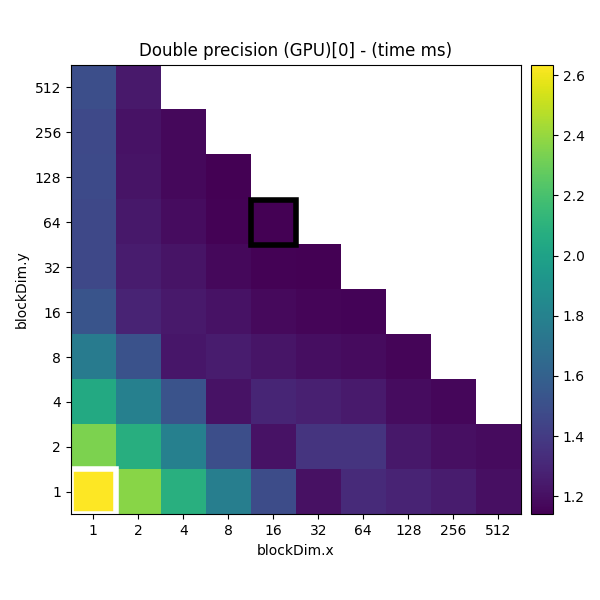

Min time is 2.727 ms, at the local size of (16,8,1).
Max TFlop/S is 0.78758671654177 +/- 1.3617245999680032e-11.
Max time is 191.867 ms, at the local size of (1,1,1).
Max time / min time == 70.367


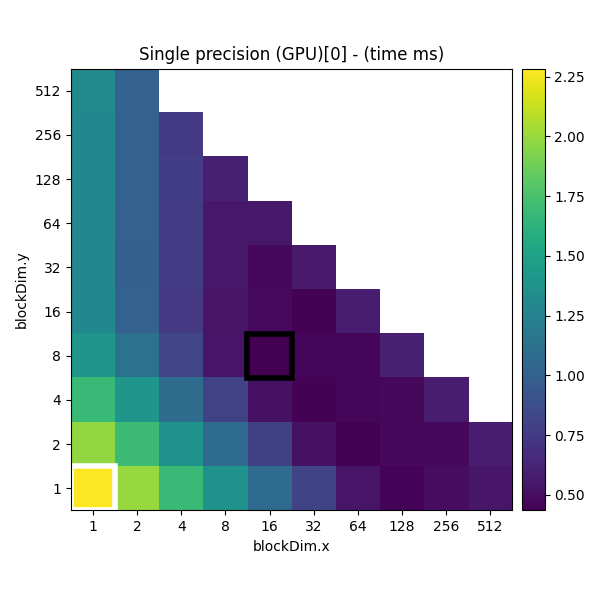

Min time is 2.624 ms, at the local size of (2,64,1).
Max TFlop/S is 0.8184240746930146 +/- 1.8345837261864412e-11.
Max time is 127.964 ms, at the local size of (1,1,1).
Max time / min time == 48.768


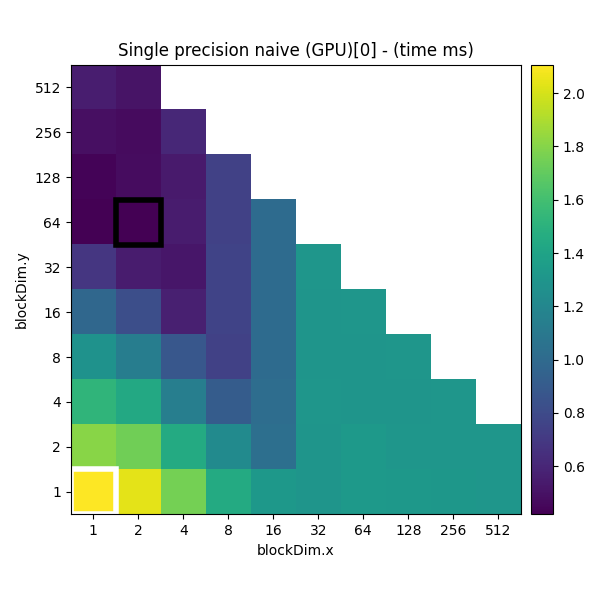

Min time is 2.752 ms, at the local size of (8,16,1).
Max TFlop/S is 0.7803305912229428 +/- 9.211982496626774e-12.
Max time is 191.948 ms, at the local size of (1,1,1).
Max time / min time == 69.748


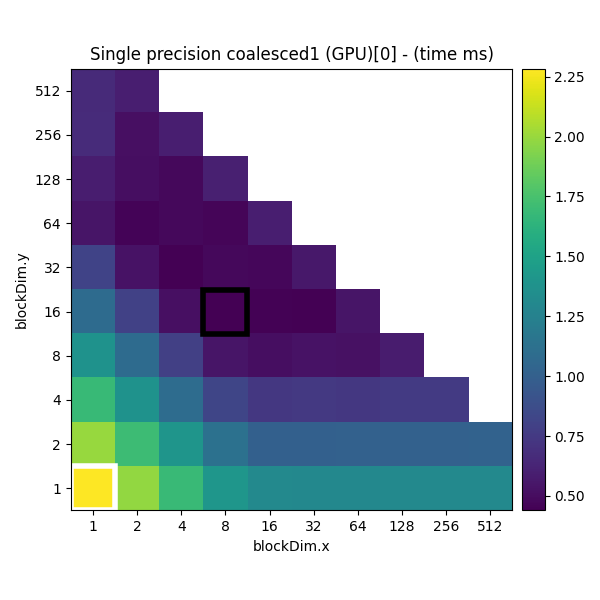

Min time is 2.582 ms, at the local size of (4,32,1).
Max TFlop/S is 0.8318707612045697 +/- 7.662237988489171e-12.
Max time is 130.143 ms, at the local size of (1,1,1).
Max time / min time == 50.413


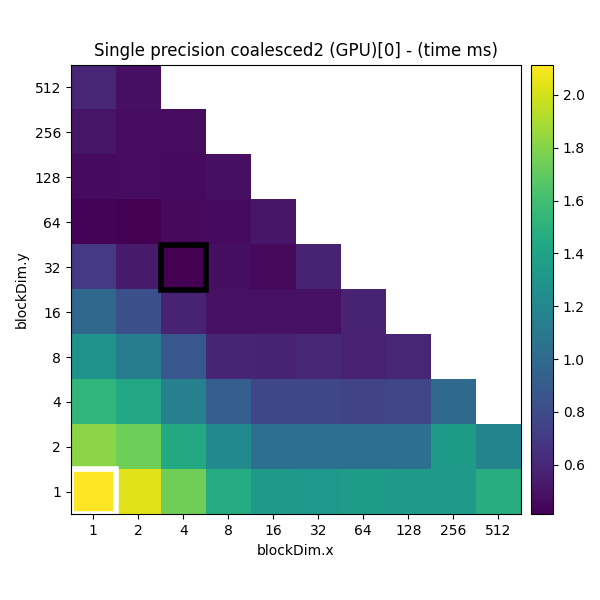

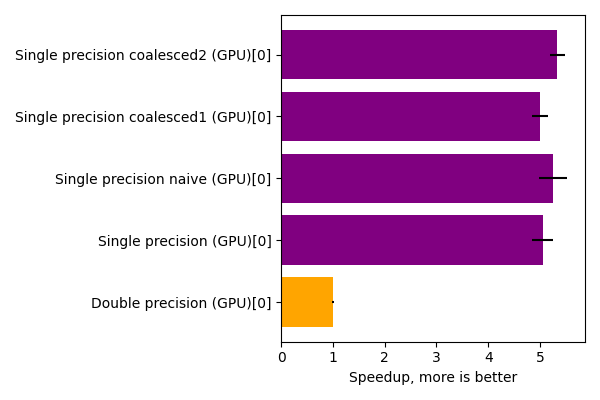

In [6]:
for label in [f'Double precision (GPU)[{gpu_id}]', 
              f'Single precision (GPU)[{gpu_id}]',
              f'Single precision naive (GPU)[{gpu_id}]',
              f'Single precision coalesced1 (GPU)[{gpu_id}]',
              f'Single precision coalesced2 (GPU)[{gpu_id}]']:
    timings.add_result(benchmark[label], label, plot=True)

timings.plot_results("Single precision")

Timing results for the GPU show that moving to 32-bit has resulted in significantly faster kernel execution time. 

#### Conclusions from precision

Unless your algorithm **requires** high precision then using lower precision numbers can improve compute performance on most compute devices. This is because memory bandwidth requirements are lower, and the hardware may be more optimised for lower precision compute.

#### Using the restrict keyword

When using pointers to reference memory objects it is possible that more than one pointer can reference the same memory location. This is called **pointer aliasing**. C and C++ codes have traditionally been at a slight performance disadvantage with respect to Fortran, because the compiler has had to allow for pointer aliasing and the memory safety allowances that must be made to account for it.

The `__restrict__` keyword is a hint to the compiler that no other pointer is going to reference the same memory allocations. It also can help with reducing register pressure as aliasing may induce more register usage. In the **mat_mult** kernel in [mat_mult_float_restrict.cpp](mat_mult_kernel_float_restrict.cpp) we use `__restrict__` keywords to annotate kernel memory.

```C++
// standard matrix multiply kernel 
__global__ void mat_mult (
        float_type* __restrict__ A, 
        float_type* __restrict__ B, 
        float_type* __restrict__ C, 
        size_t N1_A, 
        size_t N0_C,
        size_t N1_C) { 
            
    // A is of size (N0_C, N1_A)
    // B is of size (N1_A, N1_C)
    // C is of size (N0_C, N1_C)   
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We use row-major ordering for the matrices
    
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Scratch variable
    float_type temp=0.0f; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[i1+n*N1_C]; 
        }
        
        // Set the value in C 
        C[i0*N1_C+i1]=temp;
    }
} 
```

If we try this in the benchmark result we see that it doesn't make a big difference for matrix multiplication. It may yet make a difference for your code.

In [14]:
for label in [ f'Single with restrict (GPU)[{gpu_id}]']:
    timings.add_result(benchmark[label], label)

timings.plot_results("Single")

KeyError: 'Single with restrict (GPU)[0]'

### Block size optimisation and coalesced memory access

Performance is a complicated function that is dependent on the performance of the processor and how efficiently cache lines are being used. Block (workgroup) size is a way to **influence** how many thread teams participate in a block, and this has an effect on how compute devices access memory. 

Using the flag **plot=True**, we inspect the landscape of runtimes for single precision matrix multiplication in [mat_mult_float.cpp](mat_mult_float.cpp), as a function of block size along each axis. In the plot `blockDim.x` is mapped to dimension 1 of the matrices, and `blockDim.y` is mapped to dimension 0 of the matrices.

Min time is 2.763 ms, at the local size of (32,4,1).
Max time is 191.063 ms, at the local size of (1,1,1).
Max time / min time == 69.152


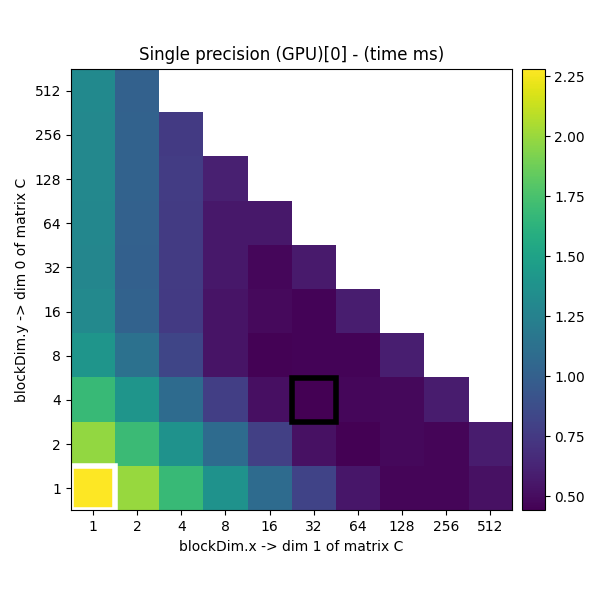

In [15]:
for label in [f'Single precision (GPU)[{gpu_id}]']:
    timings.add_result(benchmark[label], label, plot=True)

From the graph it seems that the best performing block size is one where there is an elongated number of threads in `blockDim.x`, which corresponds to dimension 1 of the matrices. If we overlay a cartoon of access to cache lines on the matrix multiplication we see that reasonably efficient cache usage is taking place along the rows of **A** because threads along row i0 have the potential to reuse parts of a cache line and the inner loop for the dot product uses adjacent memory locations. It may seem counterintuitive, but **even more efficient** cache usage is **taking place** for memory access along the columns of **B** because as we loop along the columns of **B**, cache lines are being **completely shared** by their neighbouring threads along dimension 1. 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/coalesced_memory_access.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Cache line use in matrix multiplication.</figcaption>
</figure>

When looping over arrays in kernels it might seem counterintuitive to loop over dimensions a large stride, however it is important to realise that if a neighbouring thread is also doing it too then the cache line that they each require can be shared between them and coalesced access is possible.

### Constant memory

We saw in the [Memory Management](../L6_Memory_Management/Memory.ipynb) module that **constant** memory is stored in a fast cache on the compute device. This storage space is small, on the order of a few tens to a few hundred kilobytes in size. Constant memory is read-only from the kernel, writable from the host, and is a good storage place for filter coefficients, such as is used for finite difference and convolution operations. We can't really use constant memory for matrix multiplication though.

### Rearranging memory for better access

Sometimes there can be a performance benefit if we rearrange memory prior to kernel launch with the hope of leveraging more optimal memory access patterns during execution. We saw in the block size optimisation section that coalesced memory access to **B** appears be efficient, however we would like to know for sure if that memory access more or less optimal than that of A.

#### Transpose B

Transposing is swapping the rows and columns of a matrix, where row i0 of the matrix becomes column i0 and vice-versa. In [mat_mult_BT.cpp](mat_mult_BT.cpp) we first try transposing matrix **B** to make **BT**, so that memory access for each thread along the rows of **A** and **BT**.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_transpose.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Transposed matrix multiplication.</figcaption>
</figure>

Let's see how the landscape of execution time looks.

Min time is 5.005 ms, at the local size of (8,128,1).
Max time is 57.933 ms, at the local size of (1,1,1).
Max time / min time == 11.575


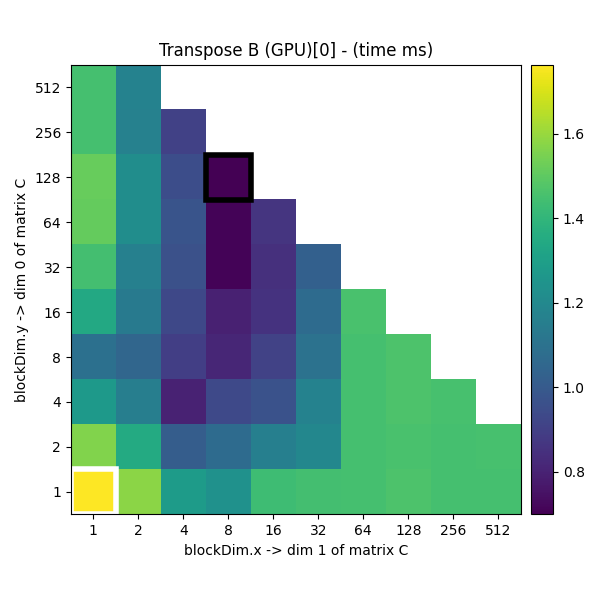

In [9]:
for label in [f"Transpose B (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label, plot=True)

For the GPU result there is a clearly defined global minimum at a block size of 
(blockDim.x, blockDim.y) = (8,128) or 1024 threads, which translates to (128,8) in the coordinate system of the matrices. Larger workgroup sizes such as 256 permit a large number of active thread teams, which is good for occupancy. Let's see how the timing results go.

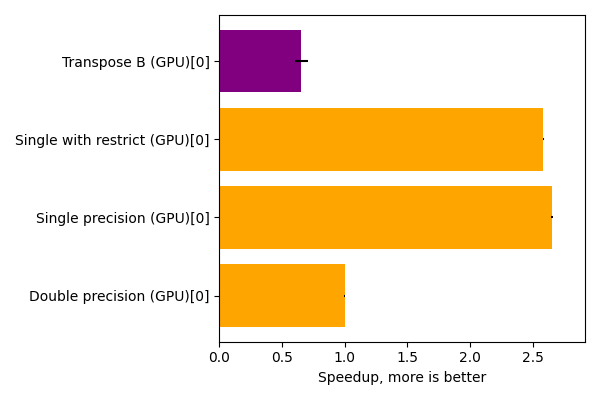

In [10]:
timings.plot_results("Transpose B")

From the peformance results above, transposing B has had a **detrimental** effect on the GPU. This is because coalesced memory access (where neighbouring work items shared memory in a cache line) is not occuring as efficiently, if at all!

#### Transposing A

Let's try transposing A instead in the code [mat_mult_AT.cpp](mat_mult_AT.cpp). Then we hope to get better performance on the GPU through leveraging coalesced access.

Min time is 2.141 ms, at the local size of (8,128,1).
Max time is 74.029 ms, at the local size of (1,1,1).
Max time / min time == 34.571


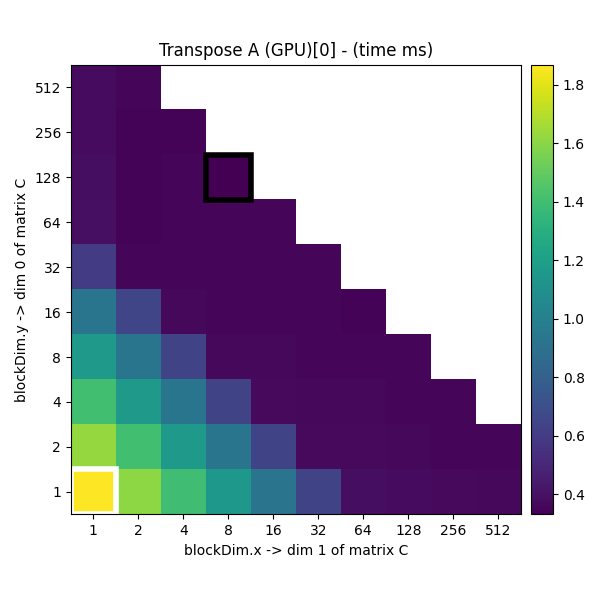

In [11]:
for label in [f"Transpose A (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label, plot=True)

The landscape of timing results show that coalesced memory access occurs far more easily when **A** is transposed, with no clear minimum at large block sizes. Let's see how the timing results go.

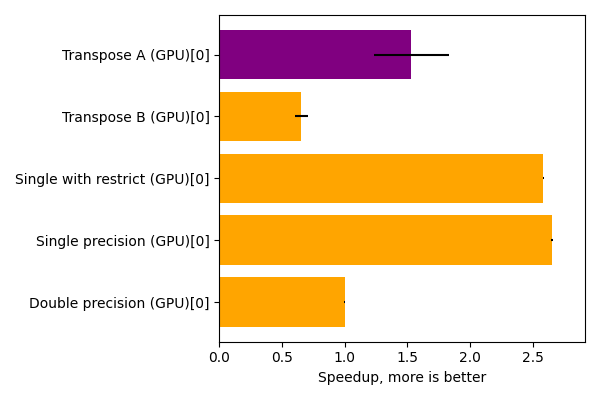

In [12]:
timings.plot_results("Transpose A")

Interestingly, the timing results from transposing A show that it is not as performant as best performing algorithm thus far ("Single precision"). This implies a limit to the amount of useful coalesced access that can take place.

### Shared memory

On GPU's shared memory uses local cache (called the local data store on AMD architectures), with a much lower latency than fetches from global memory. In the <a href="../L6_Memory_Management/Memory.ipynp">Memory Management Lesson</a> we implemented matrix multiplication implementation that **naively** copies all of the needed rows of A for block into shared memory. The source for that is in [mat_mult_shared_A.cpp](mat_mult_shared_A.cpp). 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shared_A.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using shared memory in matrix multiplication.</figcaption>
</figure>

We try two different scenarios where we use shared memory to store entire rows of A [(mat_mult_shared_A.cpp)](mat_mult_shared_A.cpp), or entire columns of B [(mat_mult_shared_B.cpp)](mat_mult_shared_B.cpp) for a block. Here is the kernel for the scenario where we cache rows of A into shared memory.

```C++
// Matrix multiply kernel that uses shared memory for A
__global__ void mat_mult_shared_A (
                        float_type* A, 
                        float_type* B, 
                        float_type* C,
                        size_t N1_A, 
                        size_t N0_C,
                        size_t N1_C) { 
    
    // Access the allocation of shared memory
    extern __shared__ char shared[];
    
    // Get a pointer to shared_A from shared
    float_type* shared_A = (float_type*)&shared[0];
    
    // A is of size (N0_C, N1_A)
    // B is of size (N1_A, N1_C)
    // shared_A is of size (L0, N1_A)
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Location within the workgroup
    size_t s0=threadIdx.y;
    size_t s1=threadIdx.x;
    
    // block size
    //size_t L0=blockDim.y;
    size_t L1=blockDim.x;
    
    // start and end positions for the copy
    size_t start, end;
    
    // Get the start and end lengths to fill array
    get_start_end(L1, N1_A, s1, &start, &end);
    
    // Fill shared_A
    if (i0<N0_C) {
        for (size_t n=start; n<end; n++) {
            shared_A[s0*N1_A+n]=A[i0*N1_A+n]; 
        }   
    }
    
    // Set a barrier to ensure that all threads 
    // sync to this point before moving on 
    __syncthreads();
    
    // Scratch variable
    // Demonstrate access of constant memory
    float_type temp=0.0f; 
    
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            // shared_B is of size (L1, N1_A)
            // C is of size (N0_C, N1_C)
            
            // Loop across row s0 of shared_A
            // and down column i1 of B
            temp+=shared_A[s0*N1_A+n]*B[n*N1_C+i1];
            
        } 
        
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
}
```

#### Shared memory and bank conflicts

Shared memory is constructed in hardware like a 2D row-major array and each column is called a bank. 
On NVIDIA compute architectures (5.0-9.0) there are 32 banks (columns), and each entry in the array at position (row_id, bank_id) can store either 32 or 64 bits (this can be adjusted at runtime in the program). There are as many rows as the device supports. 

On the AMD CDNA2 architecture for the MI250x there are also 32 banks (columns). Each entry in the array at position (row_id, bank_id) can store 32 bits, and there are 512 rows for a total of 65536 bytes available in shared memory.

A bank conflict arises when two threads in a block try to access the same bank (column) at the same time. The entry in the bank may either be broadcasted (if its at the same location) or serialised at the expense of performance. This is not so much a problem on modern architectures as they have sophisticated ways of dealing with bank conflicts, but one way to avoid a bank conflict is to have neighbouring threads access neighbouring (32-bit) elements in shared memory. Our naive approach certainly does this and we don't need to be concerened with bank conflicts for our shared memory algorithm.

Let's see how the timing landscape of these strategies compare!

Min time is 0.763 ms, at the local size of (64,4,1).
Max time is 74.959 ms, at the local size of (1,1,1).
Max time / min time == 98.196


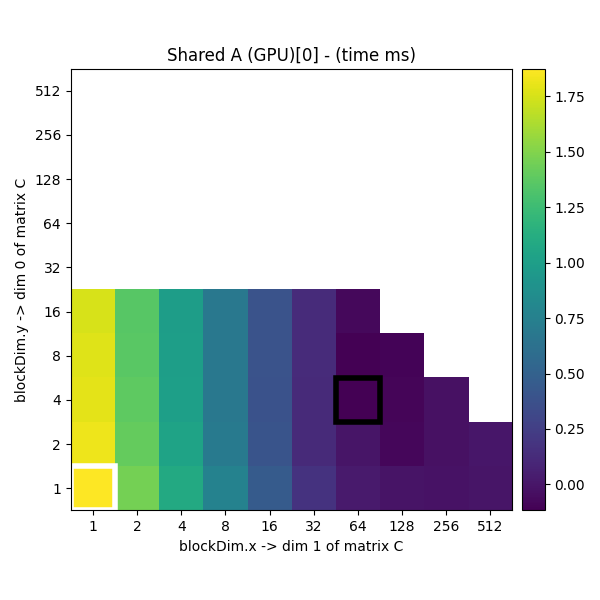

Min time is 0.938 ms, at the local size of (128,8,1).
Max time is 120.543 ms, at the local size of (1,2,1).
Max time / min time == 128.442


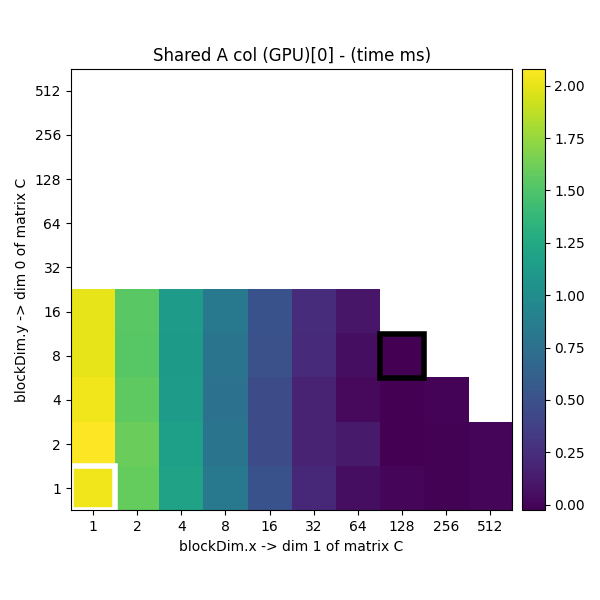

Min time is 0.849 ms, at the local size of (64,4,1).
Max time is 238.054 ms, at the local size of (1,1,1).
Max time / min time == 280.252


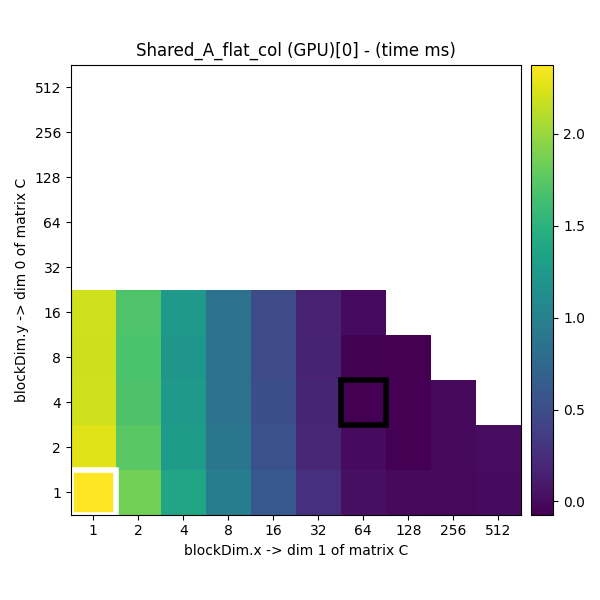

Min time is 1.127 ms, at the local size of (16,32,1).
Max time is 576.291 ms, at the local size of (1,1,1).
Max time / min time == 511.471


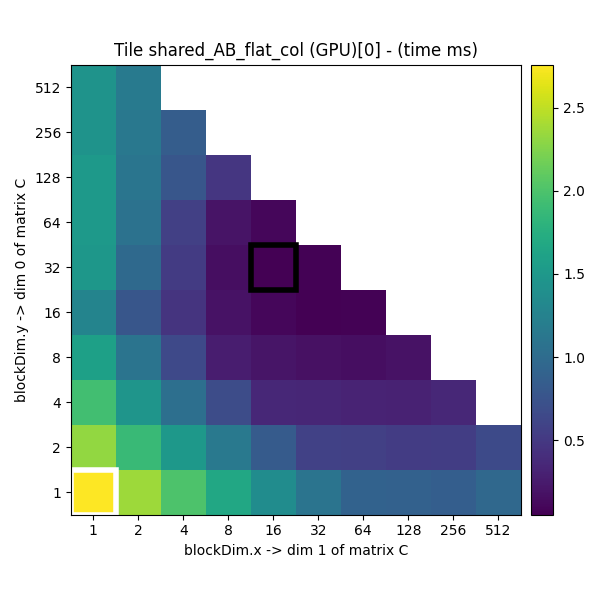

Min time is 1.351 ms, at the local size of (8,32,1).
Max time is 107.602 ms, at the local size of (1,1,1).
Max time / min time == 79.644


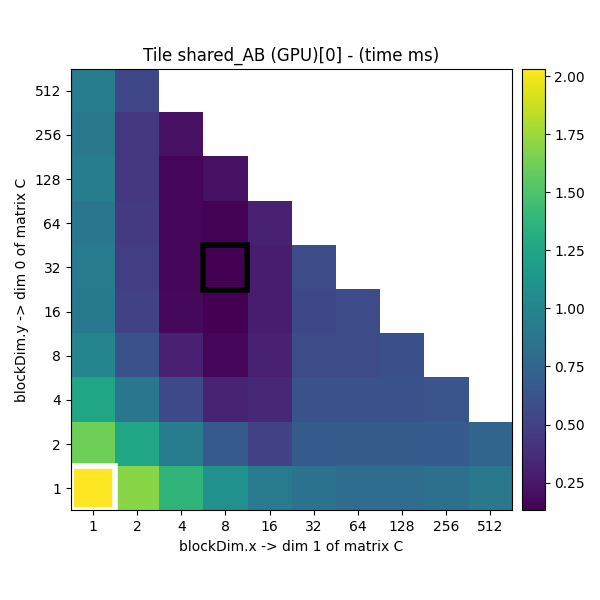

In [23]:
for label in [
    f"Shared A (GPU)[{gpu_id}]",
    f"Shared A col (GPU)[{gpu_id}]", 
    f"Shared_A_flat_col (GPU)[{gpu_id}]",
    f"Tile shared_AB_flat_col (GPU)[{gpu_id}]",
    f"Tile shared_AB (GPU)[{gpu_id}]",
]:
    timings.add_result(benchmark[label], label, plot=True)

As you can see, the landscape of valid experiments is severely curtailed by the **size** of shared memory for a block. If too many rows or columns are stored in shared memory then the calculation fails. These naive approaches are guaranteed to fail for extremely large matrix sizes. Now we show the timing results.

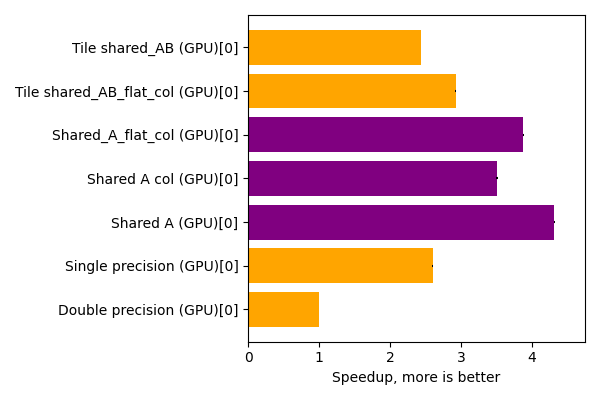

In [24]:
timings.plot_results("Shared")

From the timing results, the scenario where rows of A are stored in shared memory has produced the most performant implementation thus far. However we need a solution that reduces the amount of shared memory used.

### Tiled memory access

In order to use shared memory effectively for large arrays we need to reduce shared memory usage. One strategy is to divide up the N1_A axis (dimension 1 of **A**, and dimension 0 of **B**) into tiles of size **chunk_len** and iterate over them to accumulate the dot product. This keeps shared memory size small because only enough shared memory for one tile needs to be stored for reuse over all tiles. Then we have the option of reading tiles into shared memory from either **A**, **B** or both. A fixed tile length is also good for performance because we can make it a multiple of elements in a cache line, and enlarge N1_A (pad A and B with zeros) to make sure there is always an integer number of tiles along the N1_A axis. 

Each thread in a block iterates over all the tiles and accumulates the result of the dot product. If the block size is **(blockDim.x, blockDim.y)=(L1, L0)** then the allocations of shared memory memory for **A** and **B** are defined to be of size **(blockDim.y, chunk_len)** and **(blockDim.x, chunk_len)** respectively. Each completed tile (along row **i0** of **A** and row **i1** of **B** represents a partial dot product along the N1_A axis, and the accumulated dot product is placed into **C** at position (i0, i1).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_tile.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Matrix multiplication with chunked domain decomposition.</figcaption>
</figure>

Here is the source code for the tiled kernel in [mat_mult_tile_shared_AB.cpp](mat_mult_tile_shared_AB.cpp). Shared memory is reused for each chunk/tile. Notice that we also have to place a second `__syncthreads()` call after each tile is completed to make sure that all threads in a block are in sync before moving to the next tile.

```C++

// Source code in mat_mult_tile_shared_AB.cpp

// Matrix multiply kernel that uses shared memory for A
__global__ void mat_mult_tile_shared_AB (
                        float_type* A_star, 
                        float_type* B_star, 
                        float_type* C,
                        size_t chunk_len,
                        size_t nchunks, 
                        size_t N0_C,
                        size_t N1_C) { 
    
    // Access the allocation of shared memory
    extern __shared__ char shared[];
    
    // N1_A_star >= N1_A
    // A_star is of size (N0_C, N1_A_star)
    // B_star is of size (N1_A_star, N1_C)
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Location within the block
    size_t s0=threadIdx.y;
    size_t s1=threadIdx.x;
    
    // block size
    size_t L0=blockDim.y;
    size_t L1=blockDim.x;

    // Get a pointer to shared_A from shared
    // shared_A is of size (L0, chunk_len)
    // shared_B is of size (L1, chunk_len)
    float_type* shared_A_star = (float_type*)&shared[0];
    float_type* shared_B_star = (float_type*)&shared[L0*chunk_len*sizeof(float_type)];
    
    // Positions within shared memory
    float_type* shared_A_star_s0 = &shared_A_star[s0*chunk_len];
    float_type* shared_B_star_s1 = &shared_B_star[s1*chunk_len];
    
    // Scratch variable
    float_type temp=0.0f;
    
    // Start and end positions to copy within a chunk
    size_t start0, end0, start1, end1;
    get_start_end(L1, chunk_len, s1, &start1, &end1);
    get_start_end(L0, chunk_len, s0, &start0, &end0);
    
    // Make sure we don't go beyond the bounds of the array
    if ((i0<N0_C) && (i1<N1_C)) {
    
        // Loop over the chunks
        for (int chunk_id=0; chunk_id<nchunks; chunk_id++) {
    
            // Fill shared_A_star and shared_B_star 
            // Starting positions for the copy
            float_type* A_star_i0 = &A_star[i0*chunk_len*nchunks+chunk_id*chunk_len];
            float_type* B_star_i1 = &B_star[chunk_id*chunk_len*N1_C+i1];
        
            // Fill the rows of shared_A_star and shared_B_star
            // Copy from row i0 of A_star
            for (size_t n = start1; n<end1; n++) {
                shared_A_star_s0[n] = A_star_i0[n];
            }
        
            // Copy from column i1 of B_star   
            for (size_t n = start0; n<end0; n++) {
                shared_B_star_s1[n] = B_star_i1[n*N1_C];
            }
        
            // Synchronise threads to ensure shared memory is filled
            __syncthreads();
        
            // Loop over shared memory to compute dot product 
            // component for the chunk
            for (size_t n=0; n<chunk_len; n++) {
                
                // Perform the dot product using shared memory
                temp+=shared_A_star_s0[n]*shared_B_star_s1[n];
            }
        
            // Synchronise threads so they are
            // are ready to tackle the next tile together
            __syncthreads();
        }
    
        // Put the accumulated value into position
        C[i0*N1_C+i1]=temp;
    }
}
```


eLet's see how the performance goes with caching the tiles for A, B and then both A and B in shared memory.

In [17]:
for label in [f"Tile shared AB (GPU)[{gpu_id}]",
              f"Tile shared A (GPU)[{gpu_id}]",
              f"Tile shared B (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)

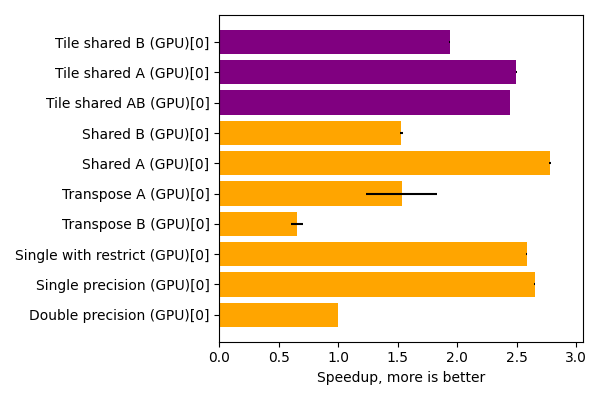

In [18]:
timings.plot_results("Tile shared")

On the GPU the tiled approach yields almost the same performance as caching the entire row in shared memory. Since memory access to B is coalesced there doesn't appear to be any need to cache the columns of B in shared memory. Because we are using a fixed chunk length we are now in a good place to consider using vector math.

### Vectors

The GPU compute units from vendors such as Intel and AMD can utilise vector instructions. Therefore using vectors to work with data in HIP *might* result in a performance boost. To my knowledge vector instructions are not supported in CUDA, though there might still be a benefit from cache performance increases because vector transfers in memory can be optimised.

Both HIP and CUDA have support for vectors up to four elements long. This is in contrast to OpenCL, which  has support for vectors up to 16 elements wide. Here we show the kernel code from [mat_mult_tile_shared_A_vector.cpp](mat_mult_tile_shared_A_vector.cpp) that stores a tile from A into local memory then uses **float4** vectors to perform the partial dot products. We need to sum over the accumulated vector **temp** at the end in order to put the result into **C**.

```C++
// Matrix multiply kernel that uses shared memory for A
__global__ void mat_mult_tile_shared_A_vector (
                        float_type* A_star, 
                        float_type* B_star, 
                        float_type* C,
                        // number of elements in a chunk
                        size_t chunk_len,
                        // number of chunks in total
                        size_t nchunks, 
                        // length of a vector
                        size_t vector_len,
                        // number of vectors in a chunk
                        size_t nvectors,
                        // dimension 0 extent of C
                        size_t N0_C,
                        // dimension 1 extent of C
                        size_t N1_C) { 
    
    // Access the allocation of shared memory
    extern __shared__ char shared[];
    
    // N1_A_star >= N1_A
    // N1_A_star = nchunks * chunk_len
    // A_star is of size (N0_C, N1_A_star)
    // B_star is of size (N1_A_star, N1_C)
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0 = blockIdx.y * blockDim.y + threadIdx.y;
    size_t i1 = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Location within the block
    size_t s0=threadIdx.y;
    size_t s1=threadIdx.x;
    
    // block size
    //size_t L0=blockDim.y;
    size_t L1=blockDim.x;

    // Get a pointer to shared_A from shared
    // shared_A is of size (L0, chunk_len)
    float_type* shared_A = (float_type*)&shared[0];

    // Line of shared memory that we are working with
    float_type* shared_A_star_s0 = &shared_A[s0*chunk_len];
    
    // Shared memory interpreted as a vector
    float_vector_type* shared_A_star_v0 = (float_vector_type*)shared_A_star_s0;
    
    // Scratch variables
    float_vector_type temp = (float_vector_type){0.0f};
    float_vector_type scratch = (float_vector_type){0.0f};
    
    // Start and end positions to copy within a chunk
    size_t start1, end1;
    get_start_end(L1, chunk_len, s1, &start1, &end1);
    
    // Make sure we don't go beyond the bounds of the array
    if ((i0<N0_C) && (i1<N1_C)) {    
    
        // Loop over the chunks
        for (int chunk_id=0; chunk_id<nchunks; chunk_id++) {
    
            // Fill shared_A_star and shared_B_star 
            // Starting positions for the copy
            float_type* A_star_i0 = &A_star[i0*chunk_len*nchunks+chunk_id*chunk_len];
            float_type* B_star_i1 = &B_star[chunk_id*chunk_len*N1_C+i1];
        
            // Fill the rows of shared_A_star and shared_B_star
            // Copy from row i0 of A_star
            for (size_t n = start1; n<end1; n++) {
                shared_A_star_s0[n] = A_star_i0[n];
            }
        
            // Synchronise threads to ensure shared memory is filled
            __syncthreads();
        
            // Loop over shared memory to compute dot product 
            // component for the chunk
            for (size_t n=0; n<nvectors; n++) {
            
                // Fill scratch from B_star_i1
                scratch.x = B_star_i1[(n*vector_len+0)*N1_C];
                scratch.y = B_star_i1[(n*vector_len+1)*N1_C];
                scratch.z = B_star_i1[(n*vector_len+2)*N1_C];
                scratch.w = B_star_i1[(n*vector_len+3)*N1_C];
            
                // Perform the dot product using shared memory          
#ifdef __HIP_PLATFORM_NVIDIA__
                temp.x += shared_A_star_v0[n].x*scratch.x;
                temp.y += shared_A_star_v0[n].y*scratch.y;
                temp.z += shared_A_star_v0[n].z*scratch.z;
                temp.w += shared_A_star_v0[n].w*scratch.w;
#else
                temp+=shared_A_star_v0[n]*scratch;
#endif
            }
        
            // Synchronise threads so they are
            // are ready to tackle the next tile together
            __syncthreads();
        }
    
        // Put the accumulated value into position
        C[i0*N1_C+i1]=temp.x+temp.y+temp.z+temp.w;
    }
}
```

Notice that we were able to perform a multiply operation on **float4** types with the AMD backend. When using a CUDA backend math operations on **float4** vectors is not supported, and we had to use CUDA-specific code to perform the vector math operations by component!

Let's see how the tiled approach goes with vector instructions!

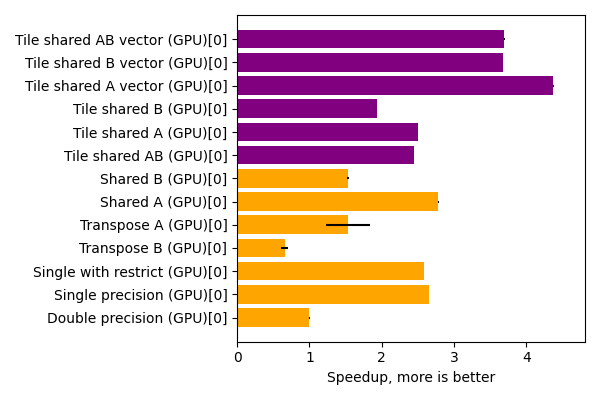

In [19]:
for label in [f"Tile shared A vector (GPU)[{gpu_id}]",
              f"Tile shared B vector (GPU)[{gpu_id}]",
              f"Tile shared AB vector (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)

timings.plot_results("Tile shared")

The tiled approach, in conjunction with shared memory and vector math on the Mi250X has made a **significant impact** on performance, with a 4.3x gain over the benchmark double precision result. 

### Use a pre-existing implementation

If your problem can be reduced to a math operation that is solved by a pre-existing implementation, then that is a way to get excellent performance. Pre-existing solvers have been worked over by experts and it is in the vendor's best interest to produce a solver that is as fast as possible.

The library [hipBLAS](https://github.com/ROCmSoftwarePlatform/hipBLAS) provides linear algebra solvers and can utilise either [rocBLAS](https://github.com/ROCmSoftwarePlatform/rocBLAS) with AMD backends, or [cuBLAS](https://developer.nvidia.com/cublas) with NVIDIA backends. The version of hipBLAS that is installed with ROCm uses the AMD backend by default, however you can download and compile the library to use a cuBLAS backend on NVIDIA hardware.

In hipBLAS, the **hipblasSgemm** function solves the generalised matrix multiplication on single precision data.

$$
\alpha \textbf{A} \cdot \textbf{B} + \beta \textbf{C} = \textbf{C}
$$

If we set $\alpha=1.0$ and $\beta=0.0$ then we have the equivalent matrix multiplication that we are using here. The code [mat_mult_float_hipblas.cpp](mat_mult_float_hipblas.cpp) demonstrates the use of **hipblasSgemm**. We first include the following header in the program.

```C++
// Bring in the hipblas header files
#include <hipblas/hipblas.h>
```

After acquiring compute devices, we initialise hipblas as follows:

```C++
    // Initialize hipblas
    hipblasHandle_t hb_handle;
    hipblasStatus_t hb_status = hipblasCreate(&hb_handle);
    if (hb_status != HIPBLAS_STATUS_SUCCESS) {
        std::printf("Failed to initialise hipBlas\n");
         exit(EXIT_FAILURE); 
    }
```

The call to **hipblasSgemm** uses column-major arrays. A row-major matrix is equivalent to a column-major matrix that is transposed. So we can use the following identity:

$$
(AB)^T = B^T A^T = C^T
$$

Then 

$$
B^{T}_{\mbox{col-major}} A^{T}_{\mbox{col-major}} = C^{T}_{\mbox{col-major}}
$$

is equivalent to

$$
B_{\mbox{row-major}} A_{\mbox{row-major}} = C_{\mbox{row-major}}
$$

Therefore, in order to use row major matrices for this function call we just need to swap inputs for **A** and **B** and adjust the input sizes.

```C
        hb_status = hipblasSgemm(
                hb_handle, // hipblas handle  
                HIPBLAS_OP_N, // what operation to apply to A (none)
                HIPBLAS_OP_N, // what operation to apply to B (none)
                (int)N1_C, // number of rows in C_{col_major} -> number of columns in C_{row_major}
                (int)N0_C, // number of columns in C_{col_major} -> number of rows in C_{row_major}
                (int)N1_A, // number of columns in A_{col_major} -> number of rows in B_{row_major}
                &alpha, // Constant
                B_d, // Normally A_{col_major} -> B^{T}_{col_major} -> B_{row_major}
                (int)N1_C, // Leading dimension for B_{row_major} 
                A_d, // Normally B_{col_major} -> A^{T}_{col_major} -> A_{row_major}
                (int)N1_A, // Leading dimension for A_{row_major}
                &beta, // Constant
                C_d, // Pointer to memory for C_{row_major}
                (int)N1_C // Leading dimension for C_{row_major}
        );
    
        if (hb_status != HIPBLAS_STATUS_SUCCESS) {
            std::printf("Failed to run hipBlas function.\n");
             exit(EXIT_FAILURE); 
        }
```

Now let's see how the timing for this went!

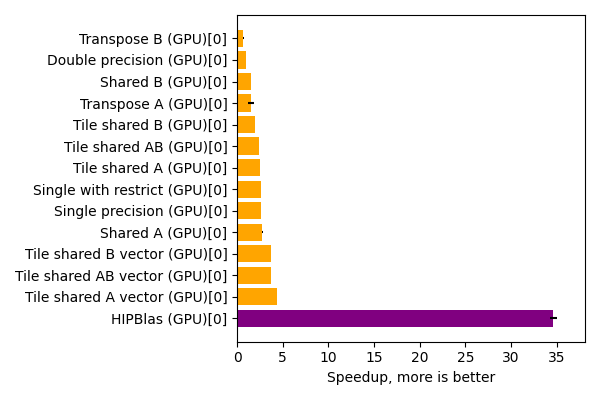

In [20]:
for label in [f"HIPBlas (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("HIPBlas", sort=True)

The optimised hipBLAS function has resulted in a speedup that is about 33x the double precision result. Canned solvers have been worked over by experts and usually get the best (or close to the best!) out of your compute hardware. It should be the first choice if your compute problem can handle it!

### Multiple compute devices

If your problem is parallelisable then you can divide the work and run it over the available compute devices. HIPBlas is clearly the best performing implementation, however the **hipblasSgemm** function doesn't appear to be able to support the execution of portions of a matrix. We can however divide the matrix up into slabs and farm out the execution of each slab to one of the available GPU's. In the figure below is a cartoon of how the matrix of size (1024,1024) is divided into slabs of size (128, N1_C). 

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/domain_decomposition.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Parallelism achived by dividing the domain of matrix C. Every available compute device is responsible for at least one domain.</figcaption>
</figure>

In the code [mat_mult_float_md_hipblas.cpp](mat_mult_float_md_hipblas.cpp) we use OpenMP with dynamic scheduling to farm out the execution of each slab to one of the available compute devices. The host array **C_h** uses pinned memory with a portable mapping so that it is available to every compute device. The resulting output slab is copied back to its place in the host array. Let's see if this makes a difference to performance.

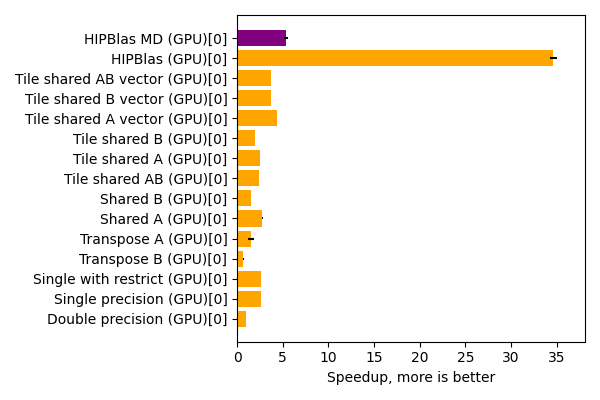

In [21]:
for label in [f"HIPBlas MD (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("HIPBlas MD (GPU)")

For this matrix size it appears that the OpenMP overheads are greater than the benefit obtained by computing a smaller section of the array on different compute devices. Therefore for this problem size the multi-gpu approach is detrimental to performance. For extremely large matrix sizes there still may be a benefit however.

### Summary

Let's plot the timing results again, this time we order by ascending speedup. This is for Setonix.

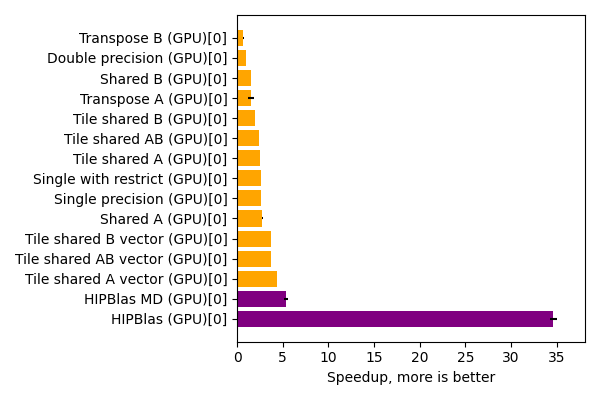

In [22]:
for label in [f"HIPBlas MD (GPU)[{gpu_id}]"]:
    timings.add_result(benchmark[label], label)
timings.plot_results("HIPBlas", sort=True)

On another computer these performance figures may be different, here are the results on my laptop. Note these numbers are relative to the double precision CPU implementation on Setonix.

* GPU 0 - NVIDIA RTX 3060 - 13 TFLOP/s peak

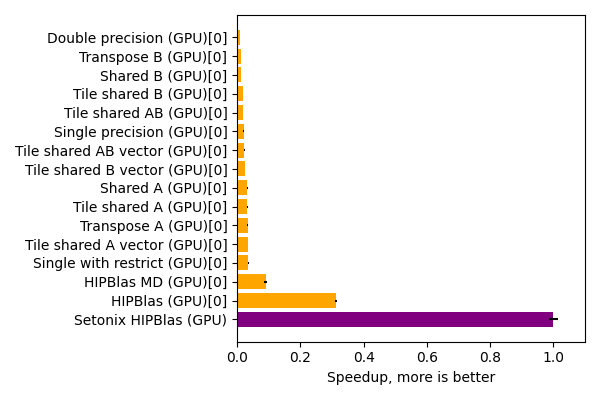

In [23]:
# Benchmark for the laptop
timings_laptop=py_helper.TimingResults()
benchmark_laptop=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "laptop.json"))
timings_laptop.add_result(benchmark['HIPBlas (GPU)[0]'], "Setonix HIPBlas (GPU)")
for label in benchmark_laptop:
    timings_laptop.add_result(benchmark_laptop[label], label)
    
timings_laptop.plot_results("Setonix HIPBlas (GPU)", sort=True)

Here are the performance numbers for my workstation. Note these numbers are relative to the double precision CPU implementation on Setonix.

* GPU 0 - AMD Radeon VII - 13 TFLOP/s

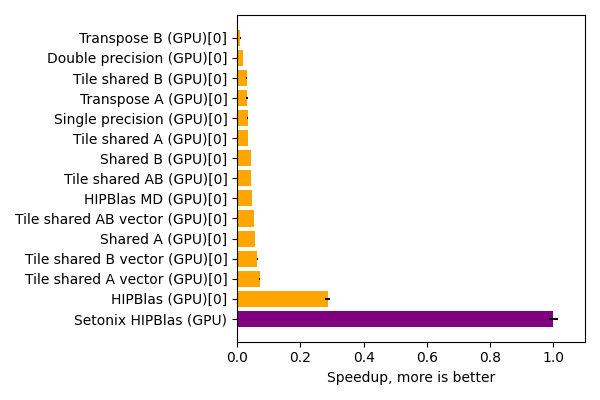

In [24]:
# Benchmark for the Workstation
benchmark_work=py_helper.load_benchmark(os.path.join(os.getcwd(), "benchmarks", "workstation.json"))
timings_work=py_helper.TimingResults()
timings_work.add_result(benchmark['HIPBlas (GPU)[0]'], "Setonix HIPBlas (GPU)")

for label in benchmark_work:
    timings_work.add_result(benchmark_work[label], label)
timings_work.plot_results("Setonix HIPBlas", sort=True)

We can distill the learnings from this exploration into a collection of principles that will help you get the best out of your HIP kernels.

* A **cache line** is the fundmental unit of memory transactions in a processor. Making best use of cache line contents is the key to good performance in HPC applications.
* GPU's have much greater **memory bandwidth** than CPU's. but also much greater **latency**.
* GPU's schedule work in lock-step over teams of math units and mitigate latency using deep pipelines with multiple teams active **at the same time**.
* For GPU's the optimum block size is a **multiple** of the team size.
* **Occupancy** is the ratio of active threads on a compute unit vs the potential number of active threads. 
    * To maximise occupancy:
        * Keep the number of registers used low. If your kernels uses too many registers per block, then consider breaking up problem to be solved over a number of smaller kernel passes instead of one pass by a large kernel.
        * Keep shared memory size low.
        * Schedule enough blocks to keep the pipeline full.
        * Large blocks work well. Use the team size to make large blocks with a multiple of thread teams, but still under the block's thread limit.
* Matrix and tensor core computations are **vendor specific** instructions, however you can use macros to maintain portability.
* Make sure your code paths have minimal **divergence** for threads in a team.
* **Arithmetic intensity** for an algorithm is the ratio of FLOPS computed per Byte of memory transferred. A low FLOPS/Byte ratio means that a computation is limited by memory bandwidth, and that is where optimisation efforts should be focused.
* The lower your **precision** the faster a computation can occur. Consider using 16-32 bit floating point numbers if you can, particularly on gaming hardware.
* Performance is a nonlinear function of block size. Consider tuning the local size to find the best one for your problem.
    * Usually large blocks (within limits) perform well
* Use **constant memory** to store coefficients and other small memory allocations.
* Use shared memory if you can:
    * Fill it in parallel using all the threads.
    * Reuse it many times within a kernel.
    * Keep it small enough to avoid occupancy issues.
* Re-arranging memory (such as transposing) prior to kernel execution might be helpful for leveraging coalesced memory access. 
* Using vectors is **essential** for gettting the best performance on compute devices that support vector instructions.
* If you can leverage someone else's solver it is a shortcut to gettting the best performance.
* Dividing your problem into subdomains and using multiple compute devices to solve each domain **might** provide a performance benefit if other overheads are small.

<address>
Written by Dr. Toby Potter of <a href="https://www.pelagos-consulting.com">Pelagos Consulting and Education</a> for the <a href="https://pawsey.org.au">Pawsey Supercomputing Research Centre</a>. All trademarks mentioned are the property of their respective owners.
</address>